In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_color_codes('deep')

In [3]:
RANDOM_STATE = 112

# Loading data

In [4]:
import sklearn.datasets
digits_dataset = sklearn.datasets.load_digits()
digits = pd.DataFrame(digits_dataset.data)
labels = pd.Series(digits_dataset.target, index=digits.index, name='label')

THRESHOLD = np.mean(digits.values.reshape(-1))
binary_digits = digits >= THRESHOLD

from sklearn.utils import shuffle
binary_digits = shuffle(binary_digits, random_state=RANDOM_STATE)
labels = labels.loc[binary_digits.index]

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [5]:
K=len(labels.unique())
D=len(binary_digits.columns)

In [6]:
def draw_digit(row, vmin=0, vmax=1, square=True, **kwargs):
    return sns.heatmap(row.astype(float).reshape(8, 8), square=square, vmin=vmin, vmax=vmax, **kwargs)

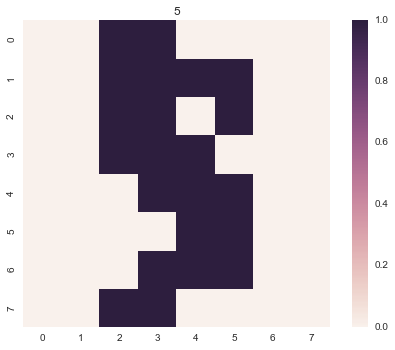

In [7]:
draw_digit(binary_digits.iloc[0])
plt.title(labels.iloc[0])

In [8]:
up_missing = binary_digits.iloc[:len(binary_digits)//4].copy()
bottom_missing = binary_digits.iloc[len(binary_digits)//4:len(binary_digits)//2].copy()
even_missing = binary_digits.iloc[len(binary_digits)//2:].copy()
up_missing.iloc[:, :D//2] = None
bottom_missing.iloc[:, D//2:] = None
even_missing.iloc[:, np.arange(0, D, 2)] = None

up_missing['dataset_id'] = 'up_missing'
bottom_missing['dataset_id'] = 'bottom_missing'
even_missing['dataset_id'] = 'even_missing'

training_data = pd.concat((up_missing, bottom_missing, even_missing))

In [9]:
training_data['weight'] = 1

In [10]:
def label_distribution(data, labels):
    ans = data[['dataset_id', 'weight']].join(labels).groupby(['dataset_id', 'label']).sum()['weight']
    ans /= ans.sum(level='dataset_id')
    
    return ans

In [11]:
from bernoullimix.random_initialisation import random_mixture_generator
N_MIXTURES_TO_TRAIN = 3
K=10

# Constraining mixing coefficients for datasets

In [12]:
training_data_same_dataset = training_data.copy()
training_data_same_dataset['dataset_id'] = 'merged'

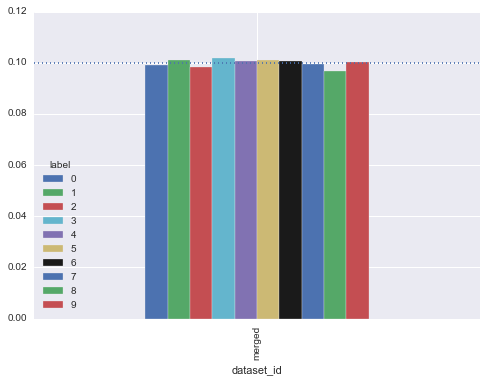

In [13]:
label_distribution(training_data_same_dataset, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [14]:
import itertools
mixtures = list(itertools.islice(random_mixture_generator(K, 
                                                          training_data_same_dataset, 
                                                          random_state=RANDOM_STATE), 
                                 N_MIXTURES_TO_TRAIN))

/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]


In [15]:
%%time
fit_results = []

for i, mixture in enumerate(mixtures):
    print('Fitting #{}'.format(i))
    
    result = mixture.fit(training_data_same_dataset, eps=1e-4, verbose=False, n_iter=None)
    print(result)
    fit_results.append(result)  
    

Fitting #0
(True, 470, -17938.700252026916)
Fitting #1
(True, 884, -17792.555231822531)
Fitting #2
(True, 1012, -17864.241488138741)
CPU times: user 7min 41s, sys: 4.74 s, total: 7min 46s
Wall time: 7min 45s


In [16]:
log_likelihoods = [x[2] for x in fit_results]

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure()
    mixture.mixing_coefficients.T.plot(kind='bar')
    plt.title('Mixture #{}. LL={}'.format(i, fit_results[i][2]))

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure(figsize=(15,15))
    for j, (component, row) in enumerate(mixture.emission_probabilities.iterrows(), start=1):
        plt.subplot(4,3,j)
        draw_digit(row)
        plt.title(component)
    plt.suptitle('Mixture #{}. LL={}'.format(i, fit_results[i][2]))
        

# Unconstrained mixture

In [ ]:
label_distribution(training_data, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [ ]:
import itertools
mixtures = list(itertools.islice(random_mixture_generator(K, 
                                                          training_data, 
                                                          random_state=RANDOM_STATE), 
                                 N_MIXTURES_TO_TRAIN))

In [ ]:
%%time
fit_results = []

for i, mixture in enumerate(mixtures):
    print('Fitting #{}'.format(i))
    
    result = mixture.fit(training_data, eps=1e-4, verbose=False, n_iter=None)
    print(result)
    fit_results.append(result)  
    

In [ ]:
log_likelihoods = [x[2] for x in fit_results]

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure()
    mixture.mixing_coefficients.T.plot(kind='bar')
    plt.title('Mixture #{}. LL={}'.format(i, fit_results[i][2]))

In [ ]:
for i, mixture in enumerate(mixtures):
    plt.figure(figsize=(15,15))
    for j, (component, row) in enumerate(mixture.emission_probabilities.iterrows(), start=1):
        plt.subplot(4,3,j)
        draw_digit(row)
        plt.title(component)
    plt.suptitle('Mixture #{}. LL={}'.format(i, fit_results[i][2]))